In [17]:
import os
import glob
import sys
import common as com
import numpy
import tqdm
import sklearn
import torch
from train import list_to_vector_array
from train import file_list_generator
from train import AutoEncoder
from train import fetch_dataloaders
import torch.nn as nn

In [18]:
########################################################################
# visualizer
########################################################################
class Visualizer(object):
    def __init__(self):
        import matplotlib.pyplot as plt
        self.plt = plt
        self.fig = self.plt.figure(figsize=(30, 10))
        self.plt.subplots_adjust(wspace=0.3, hspace=0.3)

    def loss_plot(self, loss):
        """
        Plot loss curve.
        loss : list [ float ]
            training loss time series.
        val_loss : list [ float ]
            validation loss time series.
        return   : None
        """
        ax = self.fig.add_subplot(1, 1, 1)
        ax.cla()
        ax.plot(loss)
        #设置y轴范围
        #self.plt.ylim(-5,100)
        ax.set_title("batch loss")
        ax.set_xlabel("batch")
        ax.set_ylabel("Loss")
        ax.legend(["Train", "Validation"], loc="upper right")

    def save_figure(self, name):
        """
        Save figure.
        name : str
            save png file path.
        return : None
        """
        self.plt.savefig(name)


########################################################################


In [21]:
param = com.yaml_load()
def test(dir,save):
    ab_files = file_list_generator(param["ab_dictionary"], dir_name=dir)
    com.logger.info('files num {num}'.format(num=len(ab_files)))
    ab_data = list_to_vector_array(ab_files,
                                      msg="generate train_dataset",
                                      n_mels=param["feature"]["n_mels"],
                                      frames=param["feature"]["frames"],
                                      n_fft=param["feature"]["n_fft"],
                                      hop_length=param["feature"]["hop_length"],
                                      power=param["feature"]["power"])
    ab_data = torch.Tensor(ab_data)
    com.logger.info('{dic}_data num {num}'.format(dic=dir,num=len(ab_data)))
    ab_loader = torch.utils.data.DataLoader(dataset=ab_data, batch_size=param["test_batch_size"], shuffle=True)
    model = torch.load(param["model_file"])
    loss_func = nn.MSELoss()
    features = []
    losses = []
    for data in ab_loader:
        inumpyuts = data
        feature, y = model(inumpyuts)
        loss = loss_func(y, inumpyuts)
        for one_feature in feature:
            features.append(list(one_feature))
        losses.append(loss)
    #numpy.save('feature/'+save,numpy.array(features))
    return features,losses

feature,feature_loss = test('train','feature')
ab_feature,ab_loss = test('test/abnormal','abnormal_feature')
normal_feature,normal_loss = test('test/normal','normal_feature')


2021-10-21 15:42:59,854 - INFO - target_dir : ../file/noise_detect
2021-10-21 15:42:59,856 - INFO - train_file num : 200
2021-10-21 15:42:59,857 - INFO - files num 200
generate train_dataset: 100%|██████████| 200/200 [00:03<00:00, 52.35it/s]
2021-10-21 15:43:03,691 - INFO - train_data num 11800
2021-10-21 15:43:07,284 - INFO - target_dir : ../file/noise_detect
2021-10-21 15:43:07,285 - INFO - train_file num : 4
2021-10-21 15:43:07,287 - INFO - files num 4
generate train_dataset: 100%|██████████| 4/4 [00:00<00:00, 55.95it/s]
2021-10-21 15:43:07,361 - INFO - test/abnormal_data num 236
2021-10-21 15:43:07,432 - INFO - target_dir : ../file/noise_detect
2021-10-21 15:43:07,435 - INFO - train_file num : 44
2021-10-21 15:43:07,435 - INFO - files num 44
generate train_dataset: 100%|██████████| 44/44 [00:00<00:00, 57.01it/s]
2021-10-21 15:43:08,214 - INFO - test/normal_data num 2596


In [23]:
visualizer = Visualizer()
visualizer.loss_plot(feature_loss)
visualizer.save_figure(r'pic/test/'+"debug_tag{}_".format(str(param["debug_tag"]))+'feature_loss.png')
visualizer.loss_plot(ab_loss)
visualizer.save_figure(r'pic/test/'+"debug_tag{}_".format(str(param["debug_tag"]))+'ab_loss.png')
visualizer.loss_plot(normal_loss)
visualizer.save_figure(r'pic/test/'+"debug_tag{}_".format(str(param["debug_tag"]))+'normal_loss.png')
print(len(normal_loss))

C:\ZTTTX\Programing\Anaconda\envs\noise_detect\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


82


In [71]:
# # 目前想法把train_feature,ab_feature,normal_feature同时降维观察
# import numpy as numpy
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# def plot_embedding(data, label, title):
#     x_min, x_max = numpy.min(data, 0), numpy.max(data, 0)
#     data = (data - x_min) / (x_max - x_min)
#     colors = {0:'r',1:'b'}
#     fig = plt.figure()
#     ax = plt.subplot(111)
#     for i in range(data.shape[0]):
#         plt.text(data[i, 0], data[i, 1], '.',
#                  color=colors[int(label[i])],
#                  fontdict={'weight': 'bold', 'size': 9})
#     plt.xticks([])
#     plt.yticks([])
#     plt.title(title)
#     return fig

# tsne = TSNE(n_components=2, init='pca', random_state=0)




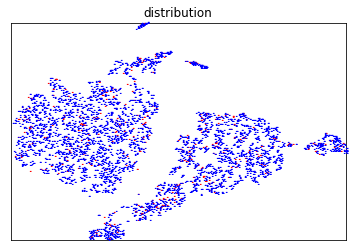

In [73]:
#部分降维
# zero = torch.zeros(len(ab_feature))
# one = torch.ones(len(normal_feature))
# label = torch.cat((zero,one),0)
# feature = ab_feature + normal_feature
# print(len(feature))
# print(len(label))
# result = tsne.fit_transform(feature[:5000])
# fig = plot_embedding(result[:5000], label[:5000],'distribution')
# plt.show(fig)

In [74]:
# result = tsne.fit_transform(feature)

In [75]:
# fig = plot_embedding(result, label,'distribution')
# plt.savefig('distribution_all.png')
# plt.show(fig)

IndexError: index 5856 is out of bounds for dimension 0 with size 5856

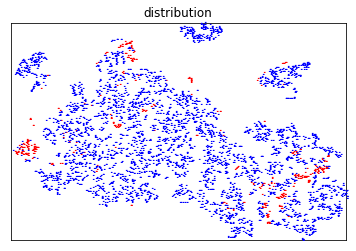

In [ ]:
# fig = plot_embedding(result[:5000], label[:5000],'distribution')
# plt.savefig('distribution_all_5000.png')
# plt.show(fig)

In [62]:
def cosine_distance(matrix1,matrix2):
    matrix1_matrix2 = numpy.dot(matrix1, matrix2.transpose())
    matrix1_norm = numpy.sqrt(numpy.multiply(matrix1, matrix1).sum(axis=1))
    matrix1_norm = matrix1_norm[:, numpy.newaxis]
    matrix2_norm = numpy.sqrt(numpy.multiply(matrix2, matrix2).sum(axis=1))
    matrix2_norm = matrix2_norm[:, numpy.newaxis]
    cosine_distance = numpy.divide(matrix1_matrix2, numpy.dot(matrix1_norm, matrix2_norm.transpose()))
    return cosine_distance

In [63]:
feature = numpy.array(feature,dtype='float64')
ab_feature = numpy.array(ab_feature,dtype='float64')
normal_feature = numpy.array(normal_feature,dtype='float64')
ab_distance = cosine_distance(ab_feature,feature)
normal_distance = cosine_distance(normal_feature,feature)

In [64]:
print(feature.shape)
print(normal_feature.shape)
print(ab_feature.shape)

print(ab_distance.shape)
print(normal_distance.shape)

(24400, 32)
(5368, 32)
(488, 32)
(488, 24400)
(5368, 24400)


In [58]:
print(ab_distance.argmax(axis=1))
print(normal_distance.argmax(axis=1))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [20]:
part_feature = numpy.array(feature[:100],dtype='float64')
part_ab_feature = numpy.array(ab_feature[:100],dtype='float64')
part_normal_feature = numpy.array(normal_feature[:100],dtype='float64')
part_ab_distance = cosine_distance(part_ab_feature,numpy.array(part_feature,dtype='float64'))
part_normal_distance = cosine_distance(part_normal_feature,numpy.array(part_feature,dtype='float64'))



In [21]:
numpy.save('distance/cos/ab_data',ab_distance.max(axis=1))
numpy.save('distance/cos/normal_data',normal_distance.max(axis=1))

In [67]:
print(ab_distance.max(axis=1))
print(normal_distance.max(axis=1))

[0.99273891 0.99560726 0.99514249 0.97242391 0.97003356 0.99319041
 0.99523092 0.98638263 0.98931742 0.99670712 0.98890144 0.99793694
 0.94077022 0.9985852  0.99702786 0.99118621 0.99375538 0.99670205
 0.99460537 0.94749481 0.99579943 0.99881002 0.99785474 0.99394829
 0.9919012  0.98890357 0.9980543  0.99597191 0.99786864 0.9735407
 0.99047389 0.95485565 0.99613073 0.99737995 0.99411047 0.99797474
 0.99374269 0.99150972 0.93680052 0.99829767 0.98758867 0.97049004
 0.99836602 0.99486164 0.99815355 0.99826491 0.95565709 0.98125034
 0.99642529 0.97091545 0.99877885 0.99872367 0.96561794 0.9954616
 0.98432312 0.99361506 0.95822037 0.99649282 0.9927918  0.9922333
 0.99761639 0.99804157 0.99891205 0.99321393 0.97925195 0.97518746
 0.99499331 0.99263039 0.9877639  0.99604511 0.98949352 0.9968697
 0.96390486 0.98601483 0.98375784 0.9969089  0.98463142 0.95568425
 0.91872241 0.92154492 0.99480255 0.99737262 0.9913797  0.99796272
 0.98846902 0.99466953 0.97658163 0.99079584 0.97248465 0.99539296

In [66]:
print(ab_distance.max(axis=1).mean())
print(normal_distance.max(axis=1).mean())

0.9862417424865559
0.9873768082552262


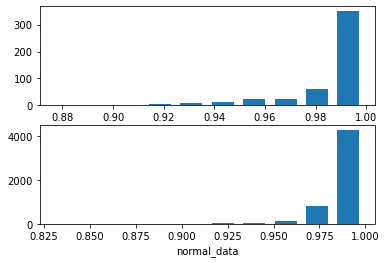

In [65]:
import matplotlib.pylab as plt 
plt.subplot(211)
plt.hist(ab_distance.max(axis=1),rwidth=0.7)
plt.xlabel("abdata")
plt.subplot(212)
plt.hist(normal_distance.max(axis=1),rwidth=0.7)
plt.xlabel("normal_data")
plt.show()